#Auto-Encoders for Runescape Community Detection

## Problems with the Previous Approach

In our previous workshop, we used PCA and TSNE for dimensionality reduction. This worked well for our dataset consisting of only 2500 points. However, the way the dataset was collected presented some major concerns.

The dataset was very small and was collected by having bots in specific areas identify other players and collect their skills data from an API. These locations were, the Bank, the Mines, and the Grand Exchange. ALthough these locations are major hubs it does not capture all types of players and the data collected didn't have enough samples.

### New Dataset

A new dataset was collected from https://www.osrs-hiscores-explorer.com/. This person scraped the OSRS-hiscores api to collect the skills of the top 2 million players. This gives us much more data to work with but presents new problems.



### Why not TSNE, PCA, or UMAP

PCA is the simplest and most peformant dimensionality reduction algorithm, however, PCA makes the assumption that our data is related linearly, which means we can lose a lot of information when using it.

TSNE although great for visualizing clusters, doesn't preserve global relationships, meaning although tight knit communities may be linked in someway, the global distance between clusters may have little to no meaning. TSNE also uses a stochastic approach to seperating clusters, meaning it is much more costly.

UMAP, although not talked about in the previous workshop, has mostly the same issues. It is extremely costly and takes too long to run on a dataset of 2 million datapoints.

Due to these limitations and an abundance of data, autoencoders prevent an alternative that allows us to capture linear and non-linear relationships in a more performant way.



# Autoencoders

<img src="https://miro.medium.com/v2/resize:fit:1400/1*44eDEuZBEsmG_TCAKRI3Kw@2x.png">

Unlike other methods that rely on mathematical transformations, autoencoders use neural networks to learn latent representations of data. They follow an encoder-decoder architecture, where the encoder compresses high-dimensional data into a compact latent space, and the decoder attempts to reconstruct the original data from this compressed representation. This process ensures that the latent space retains enough meaningful information to accurately recreate the original data.

## Use cases of AutoEncoders

### Dimenstionality Reduction

<img src="https://www.researchgate.net/publication/334647416/figure/fig7/AS:784151766654978@1563967758971/PCA-vs-Linear-auto-encoder-on-IRIS-dataset.jpg">

The most obvious use case for autoencoders is dimensionality reduction (that is what the notebooks about). This is probably the most simply way to use an autoencoder and involves training the encoder and decoder together, then using only the encoder to reduce the dimensions of your data. In this use case the decoder serves as a peripheral network for training purposes, but not for any downstream tasks.

### Image Denoising

<img src="https://www.jeremyjordan.me/content/images/2018/03/Screen-Shot-2018-03-09-at-10.20.44-AM.png">

Autoencoders can also be trained to denoise images by learning to remove noise from corrupted inputs. This is done by first adding noise to an image dataset and then training the autoencoder to map these noisy images back to their clean versions. The encoder compresses the noisy input into a latent representation, while the decoder learns to reconstruct the original image, filtering out the noise in the process. Through this training, the autoencoder learns to capture the essential features of the data while ignoring irrelevant distortions.

### Image Generation

<img src="https://lh6.googleusercontent.com/aK50TX_1y2GYoIXfB_VfzZvn1kVfOywXLLK5BfKGq_PU6qWvbC5Xvwj3AaI42ztyC7cOACcHg30BdIBBCvosOHK239ZLNEZSO99NaquUz8CTd_s2iFAcE8GCyfMzl1V-t-mlioVExsoGnHyr5Lq8pm4">

Autoencoders can also be used to for image generation. This is done by training an autoencoder to compress and uncompress images. The encoder is then removed and the decoder is fed vectors to uncompress, which can then create new images.

# The Code

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn

from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch.nn.functional as F

from mpl_toolkits.mplot3d import Axes3D


In [ ]:
df = pd.read_csv('https://media.githubusercontent.com/media/ShawnPatrick-Barhorst/OSRS_community_clustering/refs/heads/master/player-stats.csv')

In [ ]:
df

,username,rank,total,attack,defence,strength,hitpoints,ranged,prayer,magic,...,smithing,mining,herblore,agility,thieving,slayer,farming,runecraft,hunter,construction
0,Lynx Titan,1,2277,99.0,99.0,99.0,99.0,99.0,99.0,99.0,...,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0
1,Hey Jase,2,2277,99.0,99.0,99.0,99.0,99.0,99.0,99.0,...,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0
2,ShawnBay,3,2277,99.0,99.0,99.0,99.0,99.0,99.0,99.0,...,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0
3,senZe,4,2277,99.0,99.0,99.0,99.0,99.0,99.0,99.0,...,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0
4,Tomdabom,5,2277,99.0,99.0,99.0,99.0,99.0,99.0,99.0,...,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1999620,420shortribs,1999621,807,54.0,51.0,52.0,56.0,50.0,42.0,43.0,...,50.0,59.0,14.0,28.0,28.0,3.0,18.0,30.0,1.0,1.0
1999621,Luke262,1999622,807,60.0,49.0,52.0,53.0,26.0,44.0,40.0,...,39.0,45.0,24.0,29.0,25.0,45.0,1.0,38.0,9.0,2.0
1999622,Rer Eirikr,1999623,807,40.0,35.0,38.0,27.0,13.0,50.0,43.0,...,51.0,62.0,20.0,57.0,38.0,6.0,27.0,49.0,5.0,5.0
1999623,Onyxius Void,1999624,807,50.0,50.0,51.0,48.0,30.0,36.0,50.0,...,52.0,63.0,20.0,36.0,27.0,6.0,17.0,23.0,1.0,19.0


In [ ]:
class dataset(Dataset):
  def __init__(self, data, noise=0):

    self.data = data[['attack', 'defence', 'strength',
       'hitpoints', 'ranged', 'prayer', 'magic', 'cooking', 'woodcutting',
       'fletching', 'fishing', 'firemaking', 'crafting', 'smithing', 'mining',
       'herblore', 'agility', 'thieving', 'slayer', 'farming', 'runecraft',
       'hunter', 'construction']]
    self.data.fillna(0, inplace=True)

    #add noise to data to increase robustness against noise and increase seperability
    self.x = self.data + np.random.uniform(0, noise, self.data.shape)
    self.x = self.data.clip(0, 99)

    #scale data
    self.x = self.x / 99
    self.y = self.data / 99

    #convert to torch tensor
    self.x = torch.tensor(self.x.values, dtype=torch.float32)
    self.y = torch.tensor(self.y.values, dtype=torch.float32)


  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    return self.x[idx], self.y[idx]

In [ ]:
train_data = dataset(df, 0)
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)

<ipython-input-22-ab4f02d72605>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data.fillna(0, inplace=True)


## Create AutoEncoder

In [ ]:
class Encoder(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super().__init__()
    self.linear1 = nn.Linear(input_size, hidden_size)
    self.linear2 = nn.Linear(hidden_size, hidden_size)
    self.linear3 = nn.Linear(hidden_size, output_size)

    self.relu = nn.LeakyReLU(0.1)

  def forward(self, x):
    x = self.linear1(x)
    x = self.relu(x)
    x = self.linear2(x)
    x = self.relu(x)
    x = self.linear3(x)

In [ ]:
class Decoder(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super().__init__()
    self.linear1 = nn.Linear(input_size, hidden_size)
    self.linear2 = nn.Linear(hidden_size, hidden_size)
    self.linear3 = nn.Linear(hidden_size, output_size)

    self.relu = nn.LeakyReLU(0.1)
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    x = self.linear1(x)
    x = self.relu(x)
    x = self.linear2(x)
    x = self.relu(x)
    x = self.linear3(x)
    x = self.sigmoid(x)
    return x

In [ ]:
class AutoEncoder(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super().__init__()
    self.encoder = Encoder(input_size, hidden_size, output_size)
    self.decoder = Decoder(output_size, hidden_size, input_size)

  def forward(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return encoded, decoded

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = AutoEncoder(23, 14, 3).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
import tqdm
from tqdm import tqdm

##Train Autoencoder

Below is a stripped down version of the function I use for training models. It uses TQDM to give us an estimate of when the model is going to be done. The model is given the noised data as input and the unnoised data as a ground truth. The output of the autoencoder is then compared with the ground truth using MSE and the area is then backpropagated throughout the network.

In [ ]:
def train_model(model, trainloader, validloader, epochs, device):

  for epoch in range(epochs):
    model.train()
    total_loss = 0

    for train_x, train_y in tqdm(trainloader, desc=f'Epoch {epoch+1}/{epochs}', unit='batch', ncols=100):
      train_x, train_y = train_x.to(device), train_y.to(device)

      optimizer.zero_grad()
      encoded_outputs, decoded_outputs = model(train_x)
      loss = criterion(decoded_outputs, train_y)

      loss.backward()
      optimizer.step()

      total_loss += loss.item() * train_x.size(0)

    avg_loss = total_loss/len(trainloader)
    print('Training Loss: {:.6f}'.format(
        avg_loss
        ))

In [ ]:
train_model(model, train_loader, None, 3, device)

Epoch 1/3: 100%|████████████████████████████████████████| 124977/124977 [04:13<00:00, 493.77batch/s]


Training Loss: 0.278401


Epoch 2/3: 100%|████████████████████████████████████████| 124977/124977 [04:14<00:00, 491.19batch/s]


Training Loss: 0.275908


Epoch 3/3: 100%|████████████████████████████████████████| 124977/124977 [04:11<00:00, 495.98batch/s]

Training Loss: 0.273982


## Visualize Encoded Data

Below I create a function to encode all of the data. To do this I feed in the unnoised data from before, and create a list of the outputs latent space representations.

In [ ]:
def encode(model, data):
  model.eval()
  with torch.no_grad():
    return model.encoder(data).cpu().numpy()

In [ ]:
data = df[['attack', 'defence', 'strength',
              'hitpoints', 'ranged', 'prayer', 'magic', 'cooking', 'woodcutting',
             'fletching', 'fishing', 'firemaking', 'crafting', 'smithing', 'mining',
             'herblore', 'agility', 'thieving', 'slayer', 'farming', 'runecraft',
             'hunter', 'construction']]

data.fillna(0, inplace=True)
x = data / 99
x = torch.tensor(x.values, dtype=torch.float32)

x = x.to(device)

<ipython-input-80-8d96f0da3e0b>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.fillna(0, inplace=True)


In [ ]:
data

,attack,defence,strength,hitpoints,ranged,prayer,magic,cooking,woodcutting,fletching,...,smithing,mining,herblore,agility,thieving,slayer,farming,runecraft,hunter,construction
0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,...,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0
1,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,...,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0
2,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,...,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0
3,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,...,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0
4,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,...,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1999620,54.0,51.0,52.0,56.0,50.0,42.0,43.0,46.0,51.0,44.0,...,50.0,59.0,14.0,28.0,28.0,3.0,18.0,30.0,1.0,1.0
1999621,60.0,49.0,52.0,53.0,26.0,44.0,40.0,47.0,31.0,14.0,...,39.0,45.0,24.0,29.0,25.0,45.0,1.0,38.0,9.0,2.0
1999622,40.0,35.0,38.0,27.0,13.0,50.0,43.0,50.0,47.0,8.0,...,51.0,62.0,20.0,57.0,38.0,6.0,27.0,49.0,5.0,5.0
1999623,50.0,50.0,51.0,48.0,30.0,36.0,50.0,41.0,37.0,30.0,...,52.0,63.0,20.0,36.0,27.0,6.0,17.0,23.0,1.0,19.0


In [ ]:
encoded_data = encode(model, x)

In [ ]:
len(encoded_data)

1999625

I create a pandas dataframe of the outputs simply because it is easiest for me to save the data to a csv for later analysis, and because it is easier to visualize using matplotlib.

In [ ]:
encoded_df = pd.DataFrame(encoded_data, columns=['x', 'y', 'z'])

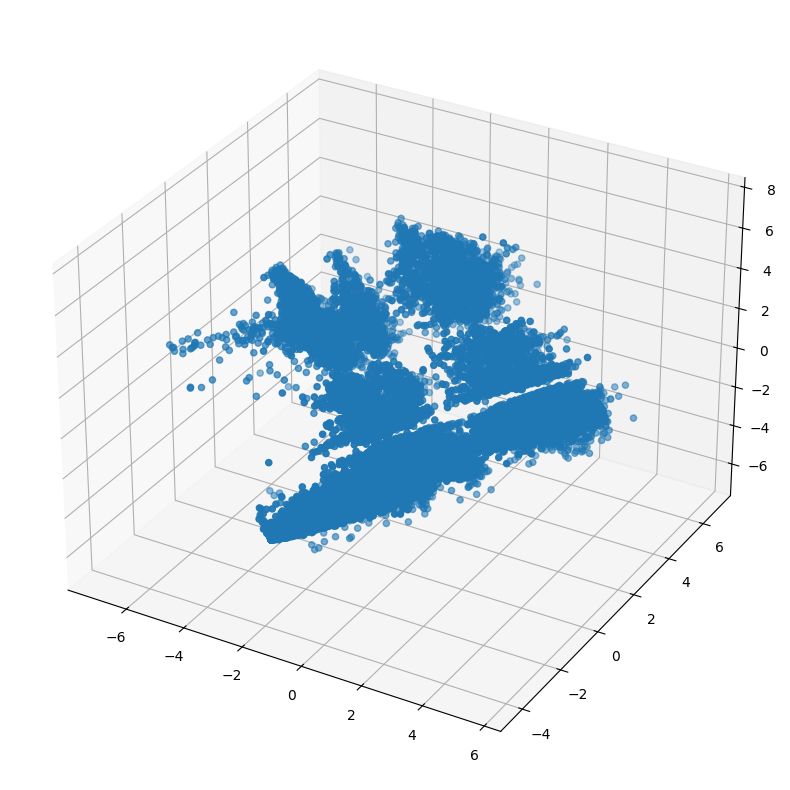

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(encoded_data[:,0], encoded_data[:,1], encoded_data[:,2])
plt.show()

In [ ]:
encoded_df.to_csv('encoded_data_2.csv', index=False)